# Deep Learning pour Classification

Ce notebook regroupe quelques configurations d'algorithmes de Deep Learning pour la classification de données.

In [1]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot



Variable                        Possibilités             Nombre de colonne (+1)
Spécialité de médecins	        33 codes de spécialité	        1-33
Sexe de médecin 	            2	                            34-35
Langue de correspondance 	    2	                            36-37
Université de graduation 	    14 universités	                38-51
Plage horaire de facturation	3 (AM, PM, toute la journée)	52-54
Agence de représentation	    845 codes d’agences             55-899
Établissements                  241 établissements	            900-1140
ActeMedical                     2 (Oui et Non)	                1141-1142
Activités médico-admin          2 (Oui et Non)	                1143-1144
Activités d’enseignement	    2 (Oui et Non)	                1145-1146
Entente LE	                    2 (Oui et Non)	                1147-1148
Activité en santé communautaire	2 (Oui et Non)	                1149-1150
Activité en santé comm. CSST	2 (Oui et Non)	                1151-1152
Activité en santé 

## 1. Enregistrement du jeu de données comportant les données avec étiquettes
Ici, le jeu de données comportant uniquement les données avec des étiquettes de classe est téléchargé. Il est ensuite séparé en jeux d'entraînement et de test en plus d'être normalisé dans toutes les dimensions.

In [2]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

## 2. Déclaration de fonctions utilitaires

In [3]:
def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

## 3. Définition du Dataset
Définition de la classe RAMQDataset, une classe qui hérite de la classe abstraite torch.utils.data.Dataset. Comme mentionné dans la documentation, les méthodes __getitem__ et __len__ sont surchargées afin d'avoir un jeu de données utilisable par PyTorch. Le data accepté en paramètres est un array numpy dont la dernière dimension est la valeur de l'étiquette.

In [4]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

## 4.1 Déclaration d'un réseau de neurones de base: 1 couche - pour référence

In [5]:
class RAMQNetBase(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self):
        super().__init__()
    
        self.F1 = nn.Linear(1182, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.F1(x)
        x = self.output(x)
        return x

## 4.2 Déclaration d'un réseau de neurones de type linéraire: multicouches
Ce réseau est personnalisable à souhait: il est possible d'y indiquer, en paramètres d'entrée, le nombre de dimensions en input, le nombre de couches linéaires à avoir dans le réseau en question et le type de la fonction d'activation qui y sera relié.

In [6]:
class RAMQNet(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build network layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

## 5. Déclaration de la fonction permettant l'affichage du pourcentage d'efficacité en classement selon 1 à 9 couches d'un réseau de neurones "x"
Cette méthode n'a besoin, en entrées, que d'un tableau des pourcentages d'efficacité pour 0 à 9 couches.

In [7]:
def plot_results(test_accu):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(1, 9)
    pyplot.grid()

    pyplot.show()

## 6. Déclaration de la fonction permettant la classification par réseau de neurones profond de type multicouches linéaire
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [17]:
def compute_linear_results(X_train, X_test, ):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" #if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32
    
    # Définit le nombre de dimensions des données avec lesquelles on travaille (la dernière dimension étant l'étiquette)
    dimensions = X_train.shape[1] - 1  

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNet
    # dans une variable nommée "model"
    for i in range(1,10):
        print("Je vais utiliser " + str(i) + " layers")
        model = RAMQNet(dimensions, i)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu)

## 7. Calcul du taux de réussite en classement d'un SVM linéaire de base sur les données non réduites - pour référence

In [17]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train[:, : -1], X_train[:, -1])
score = clf.score(X_test[:, : -1], X_test[:, -1])
print("Score on all dimensions:", score)

Score on all dimensions: 0.8361111111111111


Lorsque l'on tente de classifier les 1441 données à 1182 dimensions avec un réseau de neurones à 1 couche linéaire, on obtient un pourcentage de classement de l'ordre d'environ 82%.

## 8. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données non réduites - pour référence

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.686894 in 0.03s
 [-] epoch    2/250, train loss 0.658042 in 0.03s
 [-] epoch    3/250, train loss 0.630507 in 0.02s
 [-] epoch    4/250, train loss 0.617247 in 0.03s
 [-] epoch    5/250, train loss 0.598471 in 0.03s
 [-] epoch    6/250, train loss 0.585760 in 0.03s
 [-] epoch    7/250, train loss 0.585472 in 0.03s
 [-] epoch    8/250, train loss 0.578508 in 0.03s
 [-] epoch    9/250, train loss 0.559436 in 0.03s
 [-] epoch   10/250, train loss 0.566538 in 0.03s
 [-] epoch   11/250, train loss 0.546757 in 0.03s
 [-] epoch   12/250, train loss 0.543458 in 0.03s
 [-] epoch   13/250, train loss 0.539289 in 0.03s
 [-] epoch   14/250, train loss 0.532973 in 0.02s
 [-] epoch   15/250, train loss 0.528345 in 0.03s
 [-] epoch   16/250, train loss 0.514023 in 0.03s
 [-] epoch   17/250, train loss 0.529386 in 0.03s
 [-] epoch   18/250, train loss 0.517567 in 0.04s
 [-] epoch   19/250, train loss 0.519313 in 0.03s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.408729 in 0.03s
 [-] epoch  165/250, train loss 0.422436 in 0.03s
 [-] epoch  166/250, train loss 0.426027 in 0.03s
 [-] epoch  167/250, train loss 0.409895 in 0.03s
 [-] epoch  168/250, train loss 0.409231 in 0.03s
 [-] epoch  169/250, train loss 0.395823 in 0.03s
 [-] epoch  170/250, train loss 0.414587 in 0.03s
 [-] epoch  171/250, train loss 0.411114 in 0.03s
 [-] epoch  172/250, train loss 0.399019 in 0.03s
 [-] epoch  173/250, train loss 0.394968 in 0.03s
 [-] epoch  174/250, train loss 0.406293 in 0.03s
 [-] epoch  175/250, train loss 0.410021 in 0.03s
 [-] epoch  176/250, train loss 0.411000 in 0.03s
 [-] epoch  177/250, train loss 0.426811 in 0.03s
 [-] epoch  178/250, train loss 0.423709 in 0.03s
 [-] epoch  179/250, train loss 0.400071 in 0.03s
 [-] epoch  180/250, train loss 0.390296 in 0.03s
 [-] epoch  181/250, train loss 0.416739 in 0.03s
 [-] epoch  182/250, train loss 0.410546 in 0.03s
 [-] epoch  183/250, train loss 0.399930 in 0.03s


 [-] epoch   76/250, train loss 0.333345 in 0.08s
 [-] epoch   77/250, train loss 0.311390 in 0.07s
 [-] epoch   78/250, train loss 0.329150 in 0.07s
 [-] epoch   79/250, train loss 0.329106 in 0.07s
 [-] epoch   80/250, train loss 0.360876 in 0.07s
 [-] epoch   81/250, train loss 0.333102 in 0.06s
 [-] epoch   82/250, train loss 0.335034 in 0.08s
 [-] epoch   83/250, train loss 0.334150 in 0.08s
 [-] epoch   84/250, train loss 0.321516 in 0.07s
 [-] epoch   85/250, train loss 0.308439 in 0.07s
 [-] epoch   86/250, train loss 0.342272 in 0.08s
 [-] epoch   87/250, train loss 0.315602 in 0.07s
 [-] epoch   88/250, train loss 0.310725 in 0.07s
 [-] epoch   89/250, train loss 0.285735 in 0.07s
 [-] epoch   90/250, train loss 0.315211 in 0.07s
 [-] epoch   91/250, train loss 0.354974 in 0.07s
 [-] epoch   92/250, train loss 0.318265 in 0.07s
 [-] epoch   93/250, train loss 0.321508 in 0.07s
 [-] epoch   94/250, train loss 0.317926 in 0.07s
 [-] epoch   95/250, train loss 0.306919 in 0.08s


 [-] epoch  239/250, train loss 0.264546 in 0.07s
 [-] epoch  240/250, train loss 0.270482 in 0.07s
 [-] epoch  241/250, train loss 0.262180 in 0.06s
 [-] epoch  242/250, train loss 0.284999 in 0.07s
 [-] epoch  243/250, train loss 0.266501 in 0.07s
 [-] epoch  244/250, train loss 0.288543 in 0.08s
 [-] epoch  245/250, train loss 0.281126 in 0.06s
 [-] epoch  246/250, train loss 0.272339 in 0.08s
 [-] epoch  247/250, train loss 0.311172 in 0.07s
 [-] epoch  248/250, train loss 0.270497 in 0.07s
 [-] epoch  249/250, train loss 0.278764 in 0.07s
 [-] epoch  250/250, train loss 0.278198 in 0.06s
 [-] test acc. 81.666667%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.548998 in 0.13s
 [-] epoch    2/250, train loss 0.481776 in 0.12s
 [-] epoch    3/250, train loss 0.429799 in 0.13s
 [-] epoch    4/250, train loss 0.413195 in 0.10s
 [-] epoch    5/250, train loss 0.406080 in 0.13s
 [-] epoch    6/250, train loss 0.389216 in 0.13s
 [-] epoch    7/250, train loss 0.394210 in 0.14

 [-] epoch  151/250, train loss 0.234843 in 0.13s
 [-] epoch  152/250, train loss 0.266849 in 0.14s
 [-] epoch  153/250, train loss 0.239830 in 0.13s
 [-] epoch  154/250, train loss 0.241307 in 0.13s
 [-] epoch  155/250, train loss 0.242555 in 0.13s
 [-] epoch  156/250, train loss 0.246355 in 0.14s
 [-] epoch  157/250, train loss 0.228121 in 0.13s
 [-] epoch  158/250, train loss 0.232341 in 0.11s
 [-] epoch  159/250, train loss 0.233410 in 0.13s
 [-] epoch  160/250, train loss 0.235731 in 0.13s
 [-] epoch  161/250, train loss 0.254208 in 0.14s
 [-] epoch  162/250, train loss 0.249817 in 0.12s
 [-] epoch  163/250, train loss 0.239944 in 0.12s
 [-] epoch  164/250, train loss 0.234931 in 0.13s
 [-] epoch  165/250, train loss 0.231438 in 0.11s
 [-] epoch  166/250, train loss 0.222969 in 0.13s
 [-] epoch  167/250, train loss 0.222429 in 0.13s
 [-] epoch  168/250, train loss 0.206306 in 0.14s
 [-] epoch  169/250, train loss 0.231362 in 0.11s
 [-] epoch  170/250, train loss 0.235616 in 0.13s


 [-] epoch   63/250, train loss 0.260636 in 0.22s
 [-] epoch   64/250, train loss 0.261913 in 0.22s
 [-] epoch   65/250, train loss 0.267876 in 0.22s
 [-] epoch   66/250, train loss 0.274463 in 0.21s
 [-] epoch   67/250, train loss 0.257273 in 0.21s
 [-] epoch   68/250, train loss 0.277112 in 0.21s
 [-] epoch   69/250, train loss 0.241130 in 0.20s
 [-] epoch   70/250, train loss 0.262461 in 0.22s
 [-] epoch   71/250, train loss 0.254816 in 0.21s
 [-] epoch   72/250, train loss 0.249694 in 0.20s
 [-] epoch   73/250, train loss 0.265656 in 0.23s
 [-] epoch   74/250, train loss 0.257928 in 0.21s
 [-] epoch   75/250, train loss 0.258374 in 0.22s
 [-] epoch   76/250, train loss 0.250761 in 0.21s
 [-] epoch   77/250, train loss 0.258341 in 0.21s
 [-] epoch   78/250, train loss 0.253590 in 0.19s
 [-] epoch   79/250, train loss 0.243209 in 0.22s
 [-] epoch   80/250, train loss 0.220189 in 0.18s
 [-] epoch   81/250, train loss 0.276070 in 0.20s
 [-] epoch   82/250, train loss 0.264100 in 0.21s


 [-] epoch  226/250, train loss 0.202808 in 0.19s
 [-] epoch  227/250, train loss 0.209161 in 0.22s
 [-] epoch  228/250, train loss 0.212249 in 0.22s
 [-] epoch  229/250, train loss 0.214586 in 0.21s
 [-] epoch  230/250, train loss 0.209930 in 0.21s
 [-] epoch  231/250, train loss 0.212893 in 0.20s
 [-] epoch  232/250, train loss 0.198827 in 0.19s
 [-] epoch  233/250, train loss 0.208853 in 0.22s
 [-] epoch  234/250, train loss 0.210772 in 0.20s
 [-] epoch  235/250, train loss 0.217120 in 0.20s
 [-] epoch  236/250, train loss 0.217848 in 0.22s
 [-] epoch  237/250, train loss 0.208374 in 0.21s
 [-] epoch  238/250, train loss 0.213925 in 0.21s
 [-] epoch  239/250, train loss 0.214252 in 0.20s
 [-] epoch  240/250, train loss 0.208597 in 0.22s
 [-] epoch  241/250, train loss 0.200781 in 0.19s
 [-] epoch  242/250, train loss 0.202604 in 0.21s
 [-] epoch  243/250, train loss 0.219412 in 0.20s
 [-] epoch  244/250, train loss 0.201550 in 0.22s
 [-] epoch  245/250, train loss 0.243404 in 0.20s


 [-] epoch  138/250, train loss 0.225178 in 0.30s
 [-] epoch  139/250, train loss 0.238280 in 0.30s
 [-] epoch  140/250, train loss 0.205123 in 0.31s
 [-] epoch  141/250, train loss 0.215887 in 0.30s
 [-] epoch  142/250, train loss 0.217657 in 0.30s
 [-] epoch  143/250, train loss 0.235512 in 0.32s
 [-] epoch  144/250, train loss 0.227026 in 0.28s
 [-] epoch  145/250, train loss 0.205447 in 0.28s
 [-] epoch  146/250, train loss 0.212684 in 0.32s
 [-] epoch  147/250, train loss 0.245781 in 0.31s
 [-] epoch  148/250, train loss 0.216611 in 0.32s
 [-] epoch  149/250, train loss 0.212425 in 0.31s
 [-] epoch  150/250, train loss 0.212128 in 0.30s
 [-] epoch  151/250, train loss 0.227811 in 0.30s
 [-] epoch  152/250, train loss 0.213126 in 0.31s
 [-] epoch  153/250, train loss 0.236706 in 0.33s
 [-] epoch  154/250, train loss 0.216155 in 0.30s
 [-] epoch  155/250, train loss 0.221536 in 0.31s
 [-] epoch  156/250, train loss 0.206334 in 0.28s
 [-] epoch  157/250, train loss 0.195101 in 0.30s


 [-] epoch   50/250, train loss 0.271757 in 0.41s
 [-] epoch   51/250, train loss 0.308569 in 0.43s
 [-] epoch   52/250, train loss 0.268918 in 0.43s
 [-] epoch   53/250, train loss 0.272214 in 0.40s
 [-] epoch   54/250, train loss 0.263229 in 0.41s
 [-] epoch   55/250, train loss 0.256736 in 0.41s
 [-] epoch   56/250, train loss 0.253083 in 0.38s
 [-] epoch   57/250, train loss 0.247069 in 0.42s
 [-] epoch   58/250, train loss 0.265275 in 0.44s
 [-] epoch   59/250, train loss 0.270713 in 0.38s
 [-] epoch   60/250, train loss 0.276519 in 0.40s
 [-] epoch   61/250, train loss 0.248532 in 0.41s
 [-] epoch   62/250, train loss 0.247417 in 0.42s
 [-] epoch   63/250, train loss 0.280878 in 0.40s
 [-] epoch   64/250, train loss 0.253168 in 0.44s
 [-] epoch   65/250, train loss 0.256112 in 0.42s
 [-] epoch   66/250, train loss 0.254210 in 0.40s
 [-] epoch   67/250, train loss 0.247717 in 0.41s
 [-] epoch   68/250, train loss 0.259737 in 0.38s
 [-] epoch   69/250, train loss 0.243274 in 0.40s


 [-] epoch  213/250, train loss 0.209138 in 0.40s
 [-] epoch  214/250, train loss 0.206808 in 0.40s
 [-] epoch  215/250, train loss 0.216036 in 0.39s
 [-] epoch  216/250, train loss 0.201850 in 0.39s
 [-] epoch  217/250, train loss 0.190416 in 0.42s
 [-] epoch  218/250, train loss 0.210053 in 0.40s
 [-] epoch  219/250, train loss 0.213334 in 0.40s
 [-] epoch  220/250, train loss 0.210501 in 0.41s
 [-] epoch  221/250, train loss 0.211895 in 0.41s
 [-] epoch  222/250, train loss 0.209103 in 0.41s
 [-] epoch  223/250, train loss 0.192471 in 0.40s
 [-] epoch  224/250, train loss 0.231747 in 0.41s
 [-] epoch  225/250, train loss 0.213436 in 0.42s
 [-] epoch  226/250, train loss 0.213688 in 0.42s
 [-] epoch  227/250, train loss 0.219267 in 0.42s
 [-] epoch  228/250, train loss 0.206710 in 0.40s
 [-] epoch  229/250, train loss 0.225297 in 0.39s
 [-] epoch  230/250, train loss 0.204479 in 0.43s
 [-] epoch  231/250, train loss 0.211790 in 0.41s
 [-] epoch  232/250, train loss 0.199844 in 0.40s


 [-] epoch  125/250, train loss 0.239737 in 0.51s
 [-] epoch  126/250, train loss 0.222563 in 0.49s
 [-] epoch  127/250, train loss 0.212647 in 0.48s
 [-] epoch  128/250, train loss 0.228657 in 0.49s
 [-] epoch  129/250, train loss 0.220578 in 0.47s
 [-] epoch  130/250, train loss 0.223361 in 0.47s
 [-] epoch  131/250, train loss 0.209026 in 0.46s
 [-] epoch  132/250, train loss 0.206038 in 0.47s
 [-] epoch  133/250, train loss 0.210330 in 0.49s
 [-] epoch  134/250, train loss 0.207651 in 0.50s
 [-] epoch  135/250, train loss 0.206162 in 0.50s
 [-] epoch  136/250, train loss 0.204399 in 0.49s
 [-] epoch  137/250, train loss 0.207253 in 0.49s
 [-] epoch  138/250, train loss 0.195897 in 0.47s
 [-] epoch  139/250, train loss 0.251061 in 0.46s
 [-] epoch  140/250, train loss 0.219254 in 0.48s
 [-] epoch  141/250, train loss 0.212212 in 0.48s
 [-] epoch  142/250, train loss 0.206394 in 0.47s
 [-] epoch  143/250, train loss 0.214266 in 0.49s
 [-] epoch  144/250, train loss 0.216988 in 0.49s


 [-] epoch   37/250, train loss 0.299779 in 0.61s
 [-] epoch   38/250, train loss 0.291516 in 0.56s
 [-] epoch   39/250, train loss 0.269598 in 0.57s
 [-] epoch   40/250, train loss 0.314528 in 0.55s
 [-] epoch   41/250, train loss 0.321698 in 0.58s
 [-] epoch   42/250, train loss 0.282191 in 0.56s
 [-] epoch   43/250, train loss 0.273541 in 0.58s
 [-] epoch   44/250, train loss 0.266670 in 0.55s
 [-] epoch   45/250, train loss 0.286236 in 0.59s
 [-] epoch   46/250, train loss 0.299021 in 0.60s
 [-] epoch   47/250, train loss 0.259978 in 0.59s
 [-] epoch   48/250, train loss 0.316587 in 0.54s
 [-] epoch   49/250, train loss 0.266233 in 0.56s
 [-] epoch   50/250, train loss 0.290170 in 0.59s
 [-] epoch   51/250, train loss 0.277379 in 0.57s
 [-] epoch   52/250, train loss 0.270742 in 0.58s
 [-] epoch   53/250, train loss 0.263643 in 0.55s
 [-] epoch   54/250, train loss 0.272798 in 0.58s
 [-] epoch   55/250, train loss 0.276323 in 0.57s
 [-] epoch   56/250, train loss 0.266972 in 0.58s


 [-] epoch  200/250, train loss 0.214673 in 0.58s
 [-] epoch  201/250, train loss 0.214800 in 0.58s
 [-] epoch  202/250, train loss 0.208075 in 0.59s
 [-] epoch  203/250, train loss 0.226570 in 0.58s
 [-] epoch  204/250, train loss 0.221069 in 0.61s
 [-] epoch  205/250, train loss 0.213942 in 0.59s
 [-] epoch  206/250, train loss 0.215976 in 0.60s
 [-] epoch  207/250, train loss 0.208525 in 0.61s
 [-] epoch  208/250, train loss 0.237495 in 0.59s
 [-] epoch  209/250, train loss 0.211913 in 0.57s
 [-] epoch  210/250, train loss 0.239292 in 0.59s
 [-] epoch  211/250, train loss 0.200678 in 0.59s
 [-] epoch  212/250, train loss 0.224072 in 0.59s
 [-] epoch  213/250, train loss 0.227767 in 0.60s
 [-] epoch  214/250, train loss 0.202910 in 0.56s
 [-] epoch  215/250, train loss 0.209129 in 0.61s
 [-] epoch  216/250, train loss 0.206841 in 0.58s
 [-] epoch  217/250, train loss 0.210480 in 0.59s
 [-] epoch  218/250, train loss 0.203098 in 0.57s
 [-] epoch  219/250, train loss 0.192173 in 0.59s


 [-] epoch  112/250, train loss 0.219947 in 0.67s
 [-] epoch  113/250, train loss 0.222286 in 0.63s
 [-] epoch  114/250, train loss 0.217177 in 0.64s
 [-] epoch  115/250, train loss 0.250263 in 0.66s
 [-] epoch  116/250, train loss 0.261881 in 0.65s
 [-] epoch  117/250, train loss 0.244741 in 0.65s
 [-] epoch  118/250, train loss 0.227767 in 0.64s
 [-] epoch  119/250, train loss 0.229019 in 0.65s
 [-] epoch  120/250, train loss 0.229182 in 0.66s
 [-] epoch  121/250, train loss 0.221093 in 0.64s
 [-] epoch  122/250, train loss 0.212851 in 0.68s
 [-] epoch  123/250, train loss 0.224749 in 0.66s
 [-] epoch  124/250, train loss 0.218725 in 0.66s
 [-] epoch  125/250, train loss 0.219165 in 0.66s
 [-] epoch  126/250, train loss 0.222087 in 0.63s
 [-] epoch  127/250, train loss 0.242980 in 0.66s
 [-] epoch  128/250, train loss 0.236165 in 0.65s
 [-] epoch  129/250, train loss 0.254408 in 0.67s
 [-] epoch  130/250, train loss 0.221239 in 0.65s
 [-] epoch  131/250, train loss 0.244963 in 0.66s


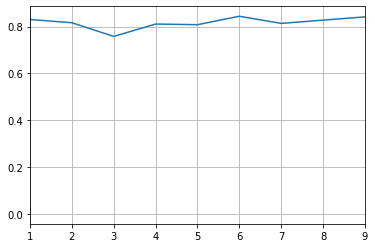

In [18]:
compute_linear_results(X_train, X_test) # all dimensions

## 9. Calcul du taux de réussite en classement d'un réseau linéaire multicouches sur les données réduites
Cette deuxième étape consiste à avoir les résultats sur les dimensions réduites engendrées par la réduction de dimensionnalité.

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.699588 in 0.97s
 [-] epoch    2/250, train loss 0.693963 in 0.02s
 [-] epoch    3/250, train loss 0.689958 in 0.02s
 [-] epoch    4/250, train loss 0.684737 in 0.02s
 [-] epoch    5/250, train loss 0.681853 in 0.02s
 [-] epoch    6/250, train loss 0.681242 in 0.02s
 [-] epoch    7/250, train loss 0.682814 in 0.02s
 [-] epoch    8/250, train loss 0.678852 in 0.02s
 [-] epoch    9/250, train loss 0.677086 in 0.02s
 [-] epoch   10/250, train loss 0.679487 in 0.02s
 [-] epoch   11/250, train loss 0.679945 in 0.02s
 [-] epoch   12/250, train loss 0.681844 in 0.02s
 [-] epoch   13/250, train loss 0.678720 in 0.02s
 [-] epoch   14/250, train loss 0.677489 in 0.02s
 [-] epoch   15/250, train loss 0.681580 in 0.02s
 [-] epoch   16/250, train loss 0.679560 in 0.02s
 [-] epoch   17/250, train loss 0.677039 in 0.02s
 [-] epoch   18/250, train loss 0.685467 in 0.02s
 [-] epoch   19/250, train loss 0.680034 in 0.02s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.648496 in 0.02s
 [-] epoch  165/250, train loss 0.644844 in 0.02s
 [-] epoch  166/250, train loss 0.652542 in 0.02s
 [-] epoch  167/250, train loss 0.641290 in 0.02s
 [-] epoch  168/250, train loss 0.648040 in 0.02s
 [-] epoch  169/250, train loss 0.650045 in 0.02s
 [-] epoch  170/250, train loss 0.641886 in 0.02s
 [-] epoch  171/250, train loss 0.637924 in 0.02s
 [-] epoch  172/250, train loss 0.653387 in 0.02s
 [-] epoch  173/250, train loss 0.646076 in 0.02s
 [-] epoch  174/250, train loss 0.643927 in 0.02s
 [-] epoch  175/250, train loss 0.648954 in 0.02s
 [-] epoch  176/250, train loss 0.653178 in 0.02s
 [-] epoch  177/250, train loss 0.651946 in 0.02s
 [-] epoch  178/250, train loss 0.633357 in 0.02s
 [-] epoch  179/250, train loss 0.652615 in 0.02s
 [-] epoch  180/250, train loss 0.654714 in 0.02s
 [-] epoch  181/250, train loss 0.646417 in 0.02s
 [-] epoch  182/250, train loss 0.634121 in 0.02s
 [-] epoch  183/250, train loss 0.636042 in 0.02s


 [-] epoch   76/250, train loss 0.568162 in 0.06s
 [-] epoch   77/250, train loss 0.576756 in 0.05s
 [-] epoch   78/250, train loss 0.577617 in 0.04s
 [-] epoch   79/250, train loss 0.561704 in 0.05s
 [-] epoch   80/250, train loss 0.567482 in 0.05s
 [-] epoch   81/250, train loss 0.583934 in 0.05s
 [-] epoch   82/250, train loss 0.592420 in 0.05s
 [-] epoch   83/250, train loss 0.576433 in 0.05s
 [-] epoch   84/250, train loss 0.557118 in 0.05s
 [-] epoch   85/250, train loss 0.565266 in 0.05s
 [-] epoch   86/250, train loss 0.554026 in 0.05s
 [-] epoch   87/250, train loss 0.579862 in 0.05s
 [-] epoch   88/250, train loss 0.567575 in 0.04s
 [-] epoch   89/250, train loss 0.589943 in 0.05s
 [-] epoch   90/250, train loss 0.589386 in 0.04s
 [-] epoch   91/250, train loss 0.579167 in 0.05s
 [-] epoch   92/250, train loss 0.566441 in 0.05s
 [-] epoch   93/250, train loss 0.567382 in 0.05s
 [-] epoch   94/250, train loss 0.592275 in 0.05s
 [-] epoch   95/250, train loss 0.574556 in 0.05s


 [-] epoch  239/250, train loss 0.570598 in 0.06s
 [-] epoch  240/250, train loss 0.566496 in 0.05s
 [-] epoch  241/250, train loss 0.565825 in 0.05s
 [-] epoch  242/250, train loss 0.569378 in 0.05s
 [-] epoch  243/250, train loss 0.538932 in 0.05s
 [-] epoch  244/250, train loss 0.551658 in 0.05s
 [-] epoch  245/250, train loss 0.556656 in 0.05s
 [-] epoch  246/250, train loss 0.548178 in 0.05s
 [-] epoch  247/250, train loss 0.575215 in 0.05s
 [-] epoch  248/250, train loss 0.558915 in 0.05s
 [-] epoch  249/250, train loss 0.556194 in 0.04s
 [-] epoch  250/250, train loss 0.546188 in 0.05s
 [-] test acc. 51.388889%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.670980 in 0.08s
 [-] epoch    2/250, train loss 0.642764 in 0.07s
 [-] epoch    3/250, train loss 0.631759 in 0.07s
 [-] epoch    4/250, train loss 0.644739 in 0.08s
 [-] epoch    5/250, train loss 0.632667 in 0.07s
 [-] epoch    6/250, train loss 0.594128 in 0.07s
 [-] epoch    7/250, train loss 0.620398 in 0.08

 [-] epoch  151/250, train loss 0.506544 in 0.07s
 [-] epoch  152/250, train loss 0.503866 in 0.07s
 [-] epoch  153/250, train loss 0.518956 in 0.08s
 [-] epoch  154/250, train loss 0.504376 in 0.07s
 [-] epoch  155/250, train loss 0.513468 in 0.07s
 [-] epoch  156/250, train loss 0.513675 in 0.07s
 [-] epoch  157/250, train loss 0.504888 in 0.07s
 [-] epoch  158/250, train loss 0.496389 in 0.07s
 [-] epoch  159/250, train loss 0.518441 in 0.07s
 [-] epoch  160/250, train loss 0.484161 in 0.06s
 [-] epoch  161/250, train loss 0.532724 in 0.07s
 [-] epoch  162/250, train loss 0.519187 in 0.07s
 [-] epoch  163/250, train loss 0.532349 in 0.06s
 [-] epoch  164/250, train loss 0.527673 in 0.08s
 [-] epoch  165/250, train loss 0.538184 in 0.07s
 [-] epoch  166/250, train loss 0.511561 in 0.07s
 [-] epoch  167/250, train loss 0.514848 in 0.06s
 [-] epoch  168/250, train loss 0.551769 in 0.07s
 [-] epoch  169/250, train loss 0.520724 in 0.07s
 [-] epoch  170/250, train loss 0.513213 in 0.07s


 [-] epoch   63/250, train loss 0.530053 in 0.08s
 [-] epoch   64/250, train loss 0.532654 in 0.07s
 [-] epoch   65/250, train loss 0.513441 in 0.10s
 [-] epoch   66/250, train loss 0.506802 in 0.09s
 [-] epoch   67/250, train loss 0.528260 in 0.10s
 [-] epoch   68/250, train loss 0.528008 in 0.13s
 [-] epoch   69/250, train loss 0.527279 in 0.11s
 [-] epoch   70/250, train loss 0.532113 in 0.11s
 [-] epoch   71/250, train loss 0.528357 in 0.11s
 [-] epoch   72/250, train loss 0.526023 in 0.11s
 [-] epoch   73/250, train loss 0.506593 in 0.10s
 [-] epoch   74/250, train loss 0.538348 in 0.10s
 [-] epoch   75/250, train loss 0.524143 in 0.11s
 [-] epoch   76/250, train loss 0.525577 in 0.11s
 [-] epoch   77/250, train loss 0.523762 in 0.09s
 [-] epoch   78/250, train loss 0.539804 in 0.09s
 [-] epoch   79/250, train loss 0.540981 in 0.08s
 [-] epoch   80/250, train loss 0.509885 in 0.10s
 [-] epoch   81/250, train loss 0.526146 in 0.09s
 [-] epoch   82/250, train loss 0.531267 in 0.08s


 [-] epoch  226/250, train loss 0.448957 in 0.10s
 [-] epoch  227/250, train loss 0.473046 in 0.09s
 [-] epoch  228/250, train loss 0.435853 in 0.09s
 [-] epoch  229/250, train loss 0.457609 in 0.11s
 [-] epoch  230/250, train loss 0.474849 in 0.09s
 [-] epoch  231/250, train loss 0.470169 in 0.08s
 [-] epoch  232/250, train loss 0.453836 in 0.09s
 [-] epoch  233/250, train loss 0.455011 in 0.09s
 [-] epoch  234/250, train loss 0.468605 in 0.08s
 [-] epoch  235/250, train loss 0.482848 in 0.09s
 [-] epoch  236/250, train loss 0.457883 in 0.06s
 [-] epoch  237/250, train loss 0.428624 in 0.08s
 [-] epoch  238/250, train loss 0.480946 in 0.08s
 [-] epoch  239/250, train loss 0.468535 in 0.07s
 [-] epoch  240/250, train loss 0.465419 in 0.10s
 [-] epoch  241/250, train loss 0.441897 in 0.08s
 [-] epoch  242/250, train loss 0.470704 in 0.08s
 [-] epoch  243/250, train loss 0.469508 in 0.10s
 [-] epoch  244/250, train loss 0.471745 in 0.08s
 [-] epoch  245/250, train loss 0.443746 in 0.11s


 [-] epoch  138/250, train loss 0.485694 in 0.10s
 [-] epoch  139/250, train loss 0.488929 in 0.10s
 [-] epoch  140/250, train loss 0.483273 in 0.11s
 [-] epoch  141/250, train loss 0.479674 in 0.10s
 [-] epoch  142/250, train loss 0.440939 in 0.10s
 [-] epoch  143/250, train loss 0.463177 in 0.10s
 [-] epoch  144/250, train loss 0.472081 in 0.10s
 [-] epoch  145/250, train loss 0.449436 in 0.09s
 [-] epoch  146/250, train loss 0.469585 in 0.10s
 [-] epoch  147/250, train loss 0.463137 in 0.10s
 [-] epoch  148/250, train loss 0.467003 in 0.09s
 [-] epoch  149/250, train loss 0.462374 in 0.10s
 [-] epoch  150/250, train loss 0.469984 in 0.10s
 [-] epoch  151/250, train loss 0.455460 in 0.10s
 [-] epoch  152/250, train loss 0.461901 in 0.10s
 [-] epoch  153/250, train loss 0.447965 in 0.10s
 [-] epoch  154/250, train loss 0.455865 in 0.10s
 [-] epoch  155/250, train loss 0.476988 in 0.10s
 [-] epoch  156/250, train loss 0.443513 in 0.10s
 [-] epoch  157/250, train loss 0.456356 in 0.10s


 [-] epoch   50/250, train loss 0.518758 in 0.11s
 [-] epoch   51/250, train loss 0.530759 in 0.11s
 [-] epoch   52/250, train loss 0.518516 in 0.13s
 [-] epoch   53/250, train loss 0.523403 in 0.13s
 [-] epoch   54/250, train loss 0.508058 in 0.10s
 [-] epoch   55/250, train loss 0.511509 in 0.12s
 [-] epoch   56/250, train loss 0.507567 in 0.10s
 [-] epoch   57/250, train loss 0.488933 in 0.10s
 [-] epoch   58/250, train loss 0.527835 in 0.12s
 [-] epoch   59/250, train loss 0.517019 in 0.14s
 [-] epoch   60/250, train loss 0.518882 in 0.12s
 [-] epoch   61/250, train loss 0.515167 in 0.13s
 [-] epoch   62/250, train loss 0.505473 in 0.12s
 [-] epoch   63/250, train loss 0.506838 in 0.11s
 [-] epoch   64/250, train loss 0.510054 in 0.12s
 [-] epoch   65/250, train loss 0.525933 in 0.13s
 [-] epoch   66/250, train loss 0.516125 in 0.14s
 [-] epoch   67/250, train loss 0.497706 in 0.11s
 [-] epoch   68/250, train loss 0.520885 in 0.10s
 [-] epoch   69/250, train loss 0.518188 in 0.11s


 [-] epoch  213/250, train loss 0.440575 in 0.14s
 [-] epoch  214/250, train loss 0.433854 in 0.11s
 [-] epoch  215/250, train loss 0.421098 in 0.12s
 [-] epoch  216/250, train loss 0.429224 in 0.12s
 [-] epoch  217/250, train loss 0.435059 in 0.12s
 [-] epoch  218/250, train loss 0.424636 in 0.12s
 [-] epoch  219/250, train loss 0.401210 in 0.12s
 [-] epoch  220/250, train loss 0.440567 in 0.13s
 [-] epoch  221/250, train loss 0.419834 in 0.13s
 [-] epoch  222/250, train loss 0.398456 in 0.11s
 [-] epoch  223/250, train loss 0.442772 in 0.13s
 [-] epoch  224/250, train loss 0.437491 in 0.11s
 [-] epoch  225/250, train loss 0.457696 in 0.13s
 [-] epoch  226/250, train loss 0.426642 in 0.13s
 [-] epoch  227/250, train loss 0.450474 in 0.13s
 [-] epoch  228/250, train loss 0.435738 in 0.11s
 [-] epoch  229/250, train loss 0.427730 in 0.11s
 [-] epoch  230/250, train loss 0.427362 in 0.13s
 [-] epoch  231/250, train loss 0.435524 in 0.13s
 [-] epoch  232/250, train loss 0.434076 in 0.14s


 [-] epoch  125/250, train loss 0.483973 in 0.15s
 [-] epoch  126/250, train loss 0.475235 in 0.15s
 [-] epoch  127/250, train loss 0.482331 in 0.13s
 [-] epoch  128/250, train loss 0.450740 in 0.15s
 [-] epoch  129/250, train loss 0.454594 in 0.16s
 [-] epoch  130/250, train loss 0.456522 in 0.14s
 [-] epoch  131/250, train loss 0.437589 in 0.15s
 [-] epoch  132/250, train loss 0.465521 in 0.15s
 [-] epoch  133/250, train loss 0.423180 in 0.17s
 [-] epoch  134/250, train loss 0.441346 in 0.15s
 [-] epoch  135/250, train loss 0.457446 in 0.14s
 [-] epoch  136/250, train loss 0.442240 in 0.13s
 [-] epoch  137/250, train loss 0.463426 in 0.13s
 [-] epoch  138/250, train loss 0.412903 in 0.15s
 [-] epoch  139/250, train loss 0.476610 in 0.14s
 [-] epoch  140/250, train loss 0.448758 in 0.15s
 [-] epoch  141/250, train loss 0.457247 in 0.14s
 [-] epoch  142/250, train loss 0.457743 in 0.12s
 [-] epoch  143/250, train loss 0.447241 in 0.15s
 [-] epoch  144/250, train loss 0.443811 in 0.14s


 [-] epoch   37/250, train loss 0.561570 in 0.16s
 [-] epoch   38/250, train loss 0.543749 in 0.15s
 [-] epoch   39/250, train loss 0.504352 in 0.15s
 [-] epoch   40/250, train loss 0.531472 in 0.13s
 [-] epoch   41/250, train loss 0.533706 in 0.14s
 [-] epoch   42/250, train loss 0.524093 in 0.15s
 [-] epoch   43/250, train loss 0.520347 in 0.14s
 [-] epoch   44/250, train loss 0.528909 in 0.15s
 [-] epoch   45/250, train loss 0.515007 in 0.15s
 [-] epoch   46/250, train loss 0.500251 in 0.14s
 [-] epoch   47/250, train loss 0.492562 in 0.14s
 [-] epoch   48/250, train loss 0.516545 in 0.15s
 [-] epoch   49/250, train loss 0.485419 in 0.15s
 [-] epoch   50/250, train loss 0.524040 in 0.13s
 [-] epoch   51/250, train loss 0.499868 in 0.12s
 [-] epoch   52/250, train loss 0.519548 in 0.13s
 [-] epoch   53/250, train loss 0.517316 in 0.16s
 [-] epoch   54/250, train loss 0.507186 in 0.17s
 [-] epoch   55/250, train loss 0.510498 in 0.15s
 [-] epoch   56/250, train loss 0.503067 in 0.16s


 [-] epoch  200/250, train loss 0.442231 in 0.14s
 [-] epoch  201/250, train loss 0.423277 in 0.15s
 [-] epoch  202/250, train loss 0.419039 in 0.15s
 [-] epoch  203/250, train loss 0.408873 in 0.15s
 [-] epoch  204/250, train loss 0.437081 in 0.13s
 [-] epoch  205/250, train loss 0.427275 in 0.17s
 [-] epoch  206/250, train loss 0.395967 in 0.14s
 [-] epoch  207/250, train loss 0.419660 in 0.12s
 [-] epoch  208/250, train loss 0.413485 in 0.12s
 [-] epoch  209/250, train loss 0.433410 in 0.14s
 [-] epoch  210/250, train loss 0.440627 in 0.14s
 [-] epoch  211/250, train loss 0.413826 in 0.15s
 [-] epoch  212/250, train loss 0.411977 in 0.14s
 [-] epoch  213/250, train loss 0.388583 in 0.16s
 [-] epoch  214/250, train loss 0.440047 in 0.15s
 [-] epoch  215/250, train loss 0.435936 in 0.15s
 [-] epoch  216/250, train loss 0.398911 in 0.15s
 [-] epoch  217/250, train loss 0.393241 in 0.14s
 [-] epoch  218/250, train loss 0.447178 in 0.15s
 [-] epoch  219/250, train loss 0.406722 in 0.16s


 [-] epoch  112/250, train loss 0.463229 in 0.17s
 [-] epoch  113/250, train loss 0.445401 in 0.17s
 [-] epoch  114/250, train loss 0.437705 in 0.16s
 [-] epoch  115/250, train loss 0.468409 in 0.15s
 [-] epoch  116/250, train loss 0.469755 in 0.18s
 [-] epoch  117/250, train loss 0.469536 in 0.14s
 [-] epoch  118/250, train loss 0.459925 in 0.16s
 [-] epoch  119/250, train loss 0.449934 in 0.16s
 [-] epoch  120/250, train loss 0.459350 in 0.15s
 [-] epoch  121/250, train loss 0.431083 in 0.17s
 [-] epoch  122/250, train loss 0.472547 in 0.16s
 [-] epoch  123/250, train loss 0.435609 in 0.17s
 [-] epoch  124/250, train loss 0.456561 in 0.16s
 [-] epoch  125/250, train loss 0.446590 in 0.13s
 [-] epoch  126/250, train loss 0.412483 in 0.17s
 [-] epoch  127/250, train loss 0.423554 in 0.16s
 [-] epoch  128/250, train loss 0.473127 in 0.17s
 [-] epoch  129/250, train loss 0.458911 in 0.14s
 [-] epoch  130/250, train loss 0.446151 in 0.18s
 [-] epoch  131/250, train loss 0.500747 in 0.16s


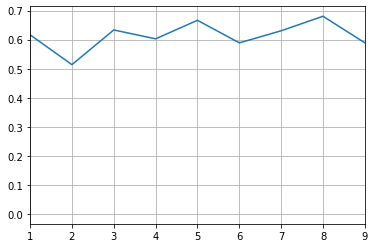

In [11]:
reducedData = numpy.load('labeled_reduit_50dim.npy')
numberOfData = reducedData.shape[0]
dimensions = reducedData.shape[1]

#print(numberOfData, dimensions)

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_reduced = minmax_scale(reducedData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_reduced = minmax_scale(reducedData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

compute_linear_results(X_train_reduced, X_test_reduced)

Classification avec fonction d'activation elu à 9 couches: +- 82% de taux de réussite

Classification avec fonction d'activation relu à 9 couches: +- 50% de taux de réussite

Tenir compte du fait que l'on n'a pas beaucoup de données considérant le nombre de dimensions

2 et 6 layers ressortent souvent (impression?) possibilité d'avoir une genre d'interférence

## 10. Déclaration de la fonction permettant la classification par réseau de neurones profond de type convolution
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

## 10. Calcul du taux de réussite en classement d'un de convolution sur les données non réduites - pour référence